<a href="https://colab.research.google.com/github/tasleema17/FINAL_PROJECT_22034202/blob/main/FloodPredictionCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Import Libraries and Packages**

Load the essential libraries needed for data processing, visualization, and model building.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV


**2.Load Datasets**

Import the datasets

In [19]:
# Load data flies
flood_data = pd.read_csv(r"/content/IndiaFloodInventory.csv")
rainfall_data = pd.read_csv(r'/content/Sub_Division_IMD_2017.csv')

In [20]:
# Display the first few rows of each dataset
print(flood_data.head())
print(rainfall_data.head())

   Unnamed: 0                   UEI        Start Date          End Date  \
0         563  UEI-IMD-FL-1967-0001  02/07/1967 00:00  08/07/1967 00:00   
1         564  UEI-IMD-FL-1967-0002  22/07/1967 00:00  28/07/1967 00:00   
2         565  UEI-IMD-FL-1967-0003  01/08/1967 00:00  30/08/1967 00:00   
3         566  UEI-IMD-FL-1967-0004  08/09/1967 00:00  09/09/1967 00:00   
4         567  UEI-IMD-FL-1968-0001  22/06/1968 00:00  28/06/1968 00:00   

   Duration(Days) Main Cause  \
0             7.0      flood   
1             7.0      flood   
2            30.0      flood   
3             2.0      flood   
4             7.0      flood   

                                           Districts  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Bhadrak, Dhenkanal, Jajapur, Subarnapur, Nuapa...   
4                                                NaN   

                   

**3.Data Transformation and Feature Engineering**

Preparing the flood_data and rainfall_data for analysis by transforming and extracting useful features

In [21]:
# Flood data processing
# Convert date columns to datetime format
flood_data['Start Date'] = pd.to_datetime(flood_data['Start Date'], format='%d/%m/%Y %H:%M')
flood_data['End Date'] = pd.to_datetime(flood_data['End Date'], format='%d/%m/%Y %H:%M')
# Extract date features
flood_data['Year'] = flood_data['Start Date'].dt.year
flood_data['Month'] = flood_data['Start Date'].dt.month
flood_data['Day'] = flood_data['Start Date'].dt.day
flood_data['Season'] = flood_data['Start Date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Monsoon
flood_data['Day of Week'] = flood_data['Start Date'].dt.dayofweek

# Rainfall data reshaping
# Melt rainfall_data to get a 'MONTH' and 'RAIN' column
rainfall_data_melted = rainfall_data.melt(
    id_vars=['SUBDIVISION', 'YEAR'],
    value_vars=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'],
    var_name='MONTH',
    value_name='RAIN'
)
# Convert month abbreviations to numeric values
month_map = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
rainfall_data_melted['MONTH'] = rainfall_data_melted['MONTH'].map(month_map)
# Ensure 'YEAR' is of type int
rainfall_data_melted['YEAR'] = rainfall_data_melted['YEAR'].astype(int)

**4.Merging the Datasets**

Combine the flood_data and rainfall_data_melted DataFrames into a single DataFrame called merged_data. It is done by matching rows based on the Year and Month columns.

In [22]:
# Merge datasets
merged_data = flood_data.merge(
    rainfall_data_melted,
    left_on=['Year', 'Month'],
    right_on=['YEAR', 'MONTH'],
    how='left'
)

**5.Data Preprocessing**

cleaning, handling missing values and standardizing

In [23]:
#merged_data['RAIN'] = merged_data['RAIN'].fillna(0)
merged_data = merged_data.drop(columns=['YEAR', 'UEI', 'Event Source', 'Year', 'Month', 'Day', 'Districts', 'Extent of damage ','Unnamed: 0'])

#Cleaning and Transforming the 'State' Column
# Ensure the 'State' column is of type string
merged_data['State'] = merged_data['State'].astype(str)
# Ensure that NaN values in 'State' are replaced with an empty string, then convert to string
merged_data['State'] = merged_data['State'].replace(pd.NA, '').astype(str)
# Split the 'State' column by commas and explode into separate rows
merged_data['State'] = merged_data['State'].str.split(', ')
merged_data_exploded = merged_data.explode('State')
# Remove any rows where 'State' is empty (after handling NaN values)
merged_data_exploded = merged_data_exploded[merged_data_exploded['State'] != '']
# Clean the 'State' column to remove extraneous characters
merged_data_exploded['State'] = merged_data_exploded['State'].str.replace(
    r"[^a-zA-Z,& ]", "", regex=True
)

#Standardizing State Names
# Define corrections dictionary to standardize state names
state_corrections = {
    "Jammu & Kashmir": "Jammu And Kashmir",
    "Daman & Diu": "Daman And Diu",
    "Maharastra": "Maharashtra",
    "Madras": "Tamil Nadu",
    "Tamilnadu": "Tamil Nadu",
    "Chennai": "Tamil Nadu",
    "Daman And Diu": "Daman,Diu",
    "Parts Of Maharastra": "Maharashtra",
    "East Rajasthan": "Rajasthan"

}
# remove leading/trailing spaces, apply title case, and apply corrections
merged_data_exploded['State'] = (
    merged_data_exploded['State']
    .str.strip()
    .str.title()
    .replace(state_corrections)
)
# Check the shape of the DataFrame
rows, columns = merged_data_exploded.shape
print(f"The DataFrame has {rows} rows and {columns} columns.")

The DataFrame has 161268 rows and 10 columns.


In [24]:
# Handling missing data and dropping columns
merged_data_exploded = merged_data_exploded.drop_duplicates()
# For 'Main Cause', fill with 'Unknown'
merged_data_exploded.loc[:, 'Main Cause'] = merged_data_exploded['Main Cause'].fillna('Unknown')
# For 'SUBDIVISION', fill with 'Unknown'
merged_data_exploded.loc[:, 'SUBDIVISION'] = merged_data_exploded['SUBDIVISION'].fillna('Unknown')
# For 'RAIN', fill with the median value
median_rain = merged_data_exploded['RAIN'].median()
merged_data_exploded.loc[:, 'RAIN'] = merged_data_exploded['RAIN'].fillna(median_rain)
# Assuming 'merged_data_exploded' is your DataFrame
merged_data_exploded = merged_data_exploded.dropna(subset=['MONTH'])

# Verify the data cleaning
print("Missing values after cleaning:\n", merged_data_exploded.isnull().sum())
print(f"\nNumber of rows and columns after cleaning: {merged_data_exploded.shape}")

Missing values after cleaning:
 Start Date        0
End Date          0
Duration(Days)    0
Main Cause        0
State             0
Season            0
Day of Week       0
SUBDIVISION       0
MONTH             0
RAIN              0
dtype: int64

Number of rows and columns after cleaning: (157248, 10)


In [25]:
#Standardizing Flood-Related Terms
# Replace 'floods' and 'heavy floods' with 'flood' in "Main Cause"
merged_data_exploded['Main Cause'] = merged_data_exploded['Main Cause'].str.lower().replace(
    {'floods': 'flood', 'heavy floods': 'flood'}, regex=True
)
#Categorizing Flood Occurrences
def categorize_cause(cause):
    # Convert to lowercase for uniform comparison
    cause_lower = cause.lower()
    # Category 1: Any term implying "flood" or "flash flood"
    if "flood" in cause_lower:
        return "flood"
    # Category 2: Descriptions mentioning "heavy rains," "landslide," or "cloud burst"
    elif any(term in cause_lower for term in ["heavy rains", "landslide", "cloud burst", "heavy rain"]):
        return "no flood"
    # Default to "no flood" if it doesn't match any criteria
    else:
        return "no flood"
# Apply the categorization function to the 'Main Cause' column
merged_data_exploded['Flood Occurance'] = merged_data_exploded['Main Cause'].apply(categorize_cause)
#Converting Categories to Numerical Values
merged_data_exploded['Flood Occurance'] = merged_data_exploded['Flood Occurance'].replace({'flood': 1, 'no flood': 0})
#Removing the Original Column
merged_data_exploded = merged_data_exploded.drop(columns=['Main Cause'])
# Count the occurrences of 'flood' and 'no flood' in the 'Flood Occurance' column
flood_counts = merged_data_exploded['Flood Occurance'].value_counts()

# Display the result
print(flood_counts)

Flood Occurance
0    121896
1     35352
Name: count, dtype: int64


<ipython-input-25-ec674bdfc5ac>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data_exploded['Flood Occurance'] = merged_data_exploded['Flood Occurance'].replace({'flood': 1, 'no flood': 0})


In [26]:
print(merged_data_exploded.head())

  Start Date   End Date  Duration(Days)  State  Season  Day of Week  \
0 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   
1 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   
2 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   
3 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   
4 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   

                          SUBDIVISION  MONTH   RAIN  Flood Occurance  
0           Andaman & Nicobar Islands    7.0  537.8                1  
1                   Arunachal Pradesh    7.0  434.5                1  
2                   Assam & Meghalaya    7.0  497.7                1  
3              Naga Mani Mizo Tripura    7.0  388.0                1  
4  Sub Himalayan West Bengal & Sikkim    7.0  901.6                1  


**6. Exploratory Data Analysis (EDA)**

<ipython-input-27-00979e072055>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data_exploded, x='SUBDIVISION', y='RAIN', palette='viridis')


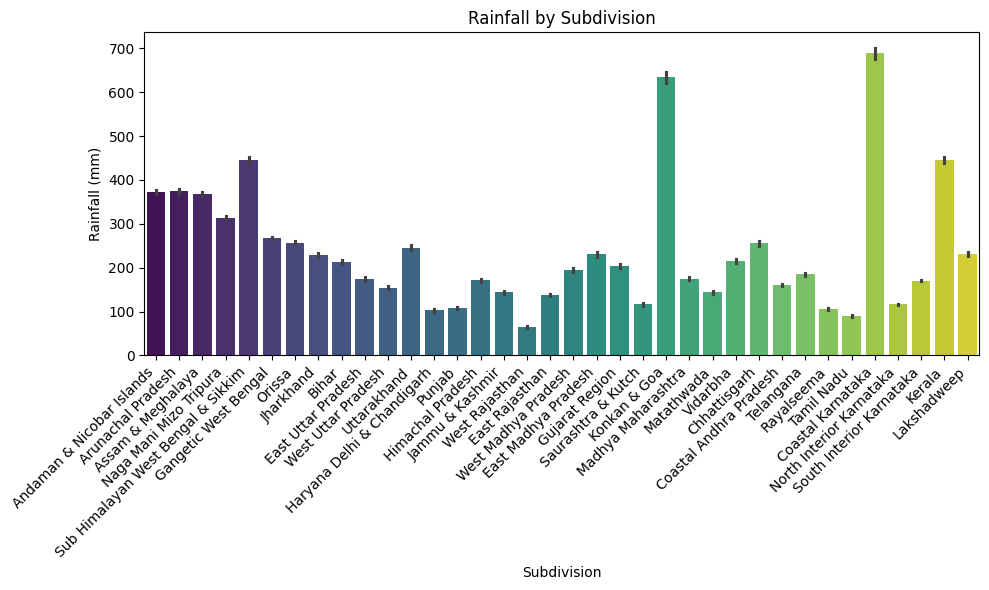

In [27]:
# Rainfall Comparison by Subdivision
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_data_exploded, x='SUBDIVISION', y='RAIN', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Rainfall by Subdivision")
plt.ylabel("Rainfall (mm)")
plt.xlabel("Subdivision")
plt.tight_layout()
plt.show()

<ipython-input-28-6c5c27b9552d>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=rainfall_per_state, x='State', y='RAIN', palette='muted', ci=None)
<ipython-input-28-6c5c27b9552d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rainfall_per_state, x='State', y='RAIN', palette='muted', ci=None)


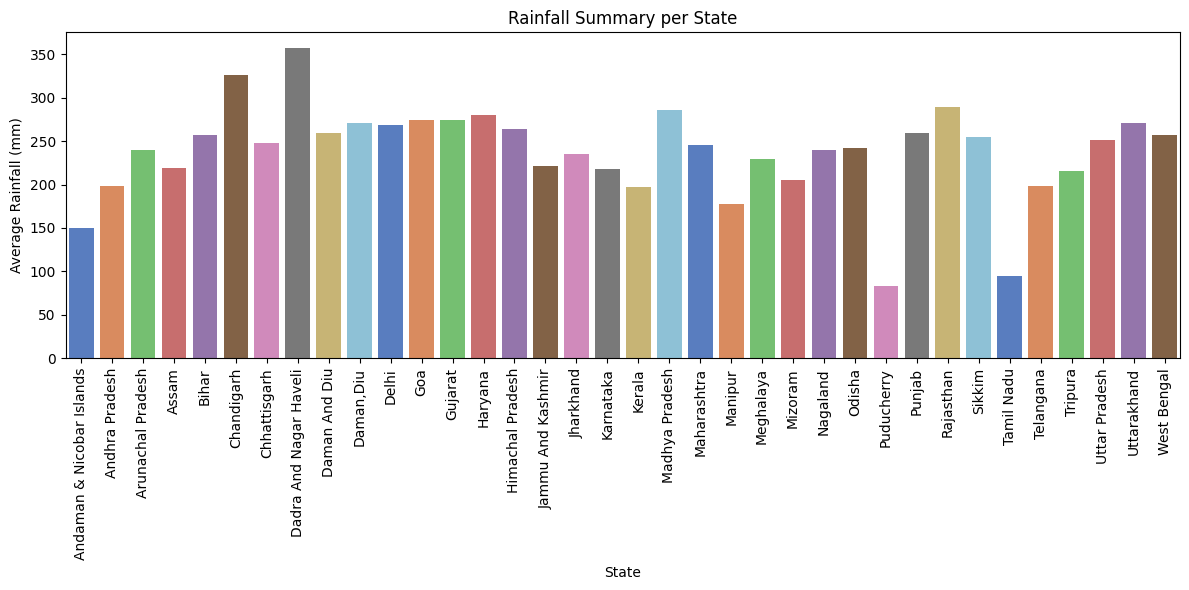

In [28]:
# Rainfall Comparison by State
# Clean the 'State' column: remove leading/trailing spaces and make all entries lowercase
merged_data_exploded['State'] = merged_data_exploded['State'].str.strip().str.title()
# Group by 'State' and calculate the average rainfall per state
rainfall_per_state = merged_data_exploded.groupby('State')['RAIN'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))  # Increase the figure size to make more room
sns.barplot(data=rainfall_per_state, x='State', y='RAIN', palette='muted', ci=None)
# Add title and labels
plt.title("Rainfall Summary per State")
plt.xlabel("State")
plt.ylabel("Average Rainfall (mm)")
# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=90)
# Adjust layout to ensure the labels fit nicely
plt.tight_layout()
# Show the plot
plt.show()

<ipython-input-29-f4eb4da5a905>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, x='State', y='RAIN', palette='magma')


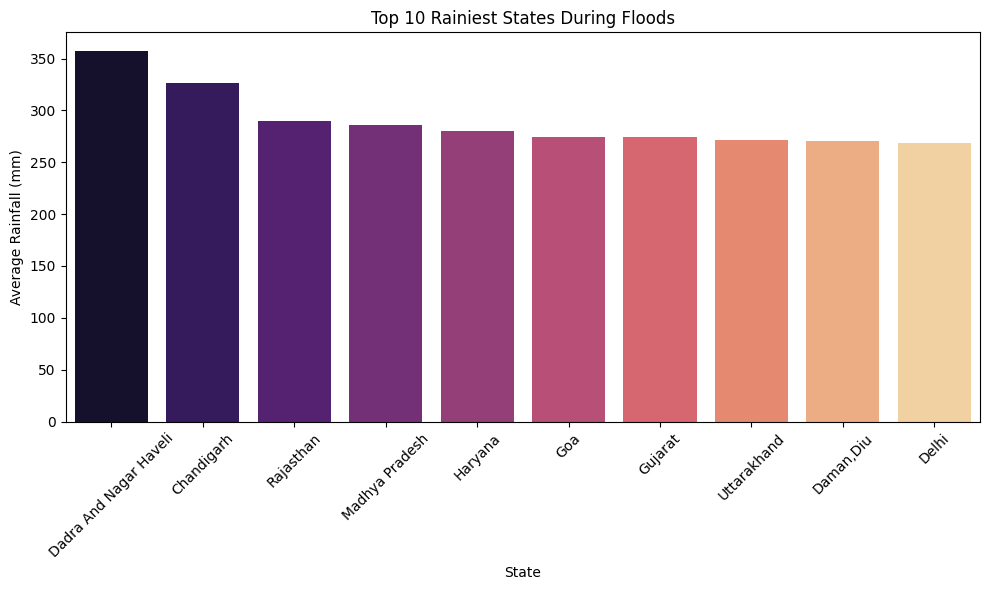

In [29]:
# Top 10 Rainiest States During Floods
top_states = merged_data_exploded.groupby('State')['RAIN'].mean().nlargest(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_states, x='State', y='RAIN', palette='magma')
plt.title("Top 10 Rainiest States During Floods")
plt.xlabel("State")
plt.ylabel("Average Rainfall (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**7. Data Splitting into Training and Testing Sets**

In [30]:
# Identify numeric columns
numeric_cols = merged_data_exploded.select_dtypes(include='number').columns
# Fill missing values in numeric columns with the mean of each column
merged_data_exploded[numeric_cols] = merged_data_exploded[numeric_cols].fillna(merged_data_exploded[numeric_cols].mean())
# fill missing values for categorical columns
merged_data_exploded = merged_data_exploded.fillna({'State': 'Unknown', 'SUBDIVISION': 'Unknown'})
# Convert categorical variables to dummy/indicator variables
merged_data_exploded = pd.get_dummies(merged_data_exploded, columns=['State', 'SUBDIVISION'], drop_first=True)
# Select features and target variable
X = merged_data_exploded.drop(columns=['Flood Occurance', 'Start Date', 'End Date'])
y = merged_data_exploded['Flood Occurance']
# Scale numerical features
scaler = StandardScaler()
X[['RAIN', 'MONTH', 'Duration(Days)']] = scaler.fit_transform(X[['RAIN', 'MONTH', 'Duration(Days)']])


In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (125798, 75)
X_test: (31450, 75)
y_train: (125798,)
y_test: (31450,)


**8. Random Undersampling**

In [32]:
# Apply RandomUnderSampler to the training data
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


**9. Model Training and Evaluation**

In [33]:
# 2. Random Forest Model Training and Tuning
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                              scoring='precision', cv=5, verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print("Best Parameters (Random Forest):", best_params_rf)

# Use the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the optimized Random Forest model
y_pred_rf = best_rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Predict probabilities for ROC AUC
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print("Random Forest Model Evaluation Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("ROC AUC:", roc_auc_rf)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters (Random Forest): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Random Forest Model Evaluation Metrics:
Accuracy: 0.8482670906200318
Precision: 0.6149561629706034
Recall: 0.8515926296243393
F1 Score: 0.714183037853378
ROC AUC: 0.92639443379214


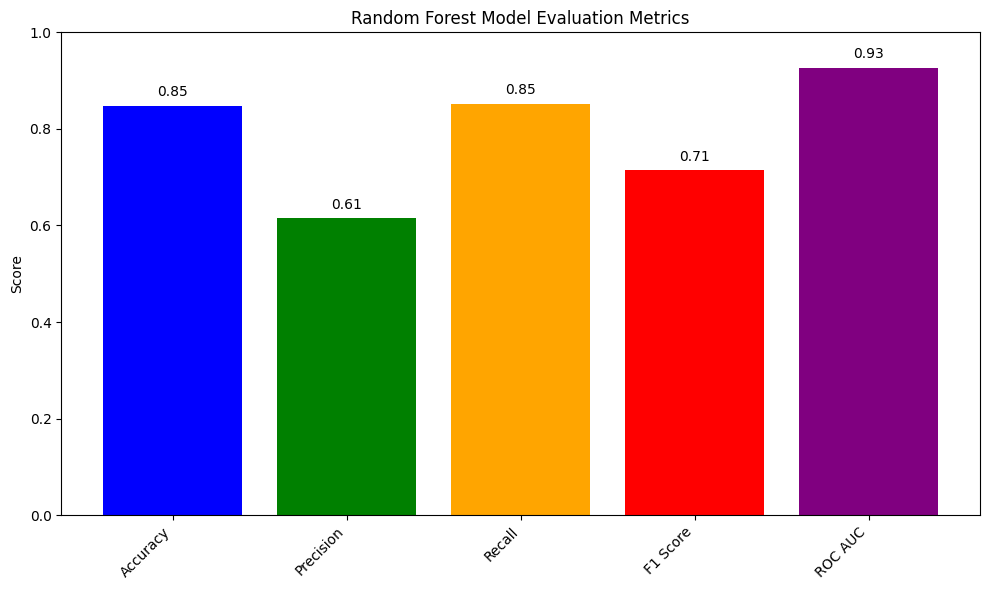

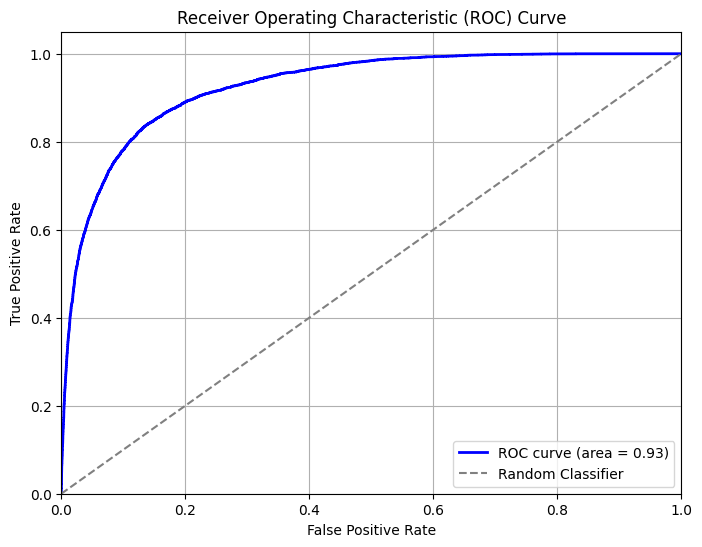

In [34]:
#Result Analysis
# Assuming you have already calculated these metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
values = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]
# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Random Forest Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for better visualization of scores
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
# Add value labels on top of the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', color='black')
plt.show()

#ROC-AUC curve
# Get predicted probabilities for the positive class (Flood = 1)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [35]:
#LSTM Model

# Step 1: Select features and target variable
#X = merged_data_exploded.drop(columns=['Start Date', 'End Date', 'Flood Occurance'])  # Drop irrelevant columns
#y = merged_data_exploded['Flood Occurance']  # Target variable

# Step 2: Split data into training and testing sets (BEFORE resampling and scaling)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print('X_train:', X_train.shape)
#print('X_test:', X_test.shape)
#print('y_train:', y_train.shape)
#print('y_test:', y_test.shape)

# Step 3: Apply RandomUnderSampler to the training data
#rus = RandomUnderSampler(random_state=42)
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Step 4: Scale numerical features (AFTER resampling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 5: Convert target variable to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train_resampled)  # For resampled training data
y_test_categorical = to_categorical(y_test)  # For original test data

# Step 6: Reshape data for LSTM
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# Step 7: Build the LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

# Step 8: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 9: Train the model
history = model.fit(
    X_train_lstm, y_train_categorical,
    validation_data=(X_test_lstm, y_test_categorical),
    epochs=40,
    batch_size=32,
    verbose=1
)

# Step 10: Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_lstm, y_test_categorical)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Step 11: Make predictions
y_pred_proba = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.6690 - loss: 0.6094 - val_accuracy: 0.7286 - val_loss: 0.5491
Epoch 2/40
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.7140 - loss: 0.5643 - val_accuracy: 0.7122 - val_loss: 0.5604
Epoch 3/40
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7220 - loss: 0.5510 - val_accuracy: 0.7182 - val_loss: 0.5636
Epoch 4/40
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.7251 - loss: 0.5453 - val_accuracy: 0.7412 - val_loss: 0.5233
Epoch 5/40
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.7319 - loss: 0.5335 - val_accuracy: 0.7399 - val_loss: 0.5167
Epoch 6/40
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7350 - loss: 0.5253 - val_accuracy: 0.7183 - val_loss: 0.5442
Epoch 7/40
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7383 - loss: 0.5182 - val_accuracy: 0.7226 - val_loss: 0.5388
Epoch 8/40
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7418 - loss: 0

In [36]:

# 1. Convert predictions to binary class labels (if needed)
y_pred = np.argmax(y_pred_proba, axis=1)  # Get predicted class labels
y_true = np.argmax(y_test_categorical, axis=1)  # Get true class labels

# 2. Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])  # Use probabilities for class 1

# 3. Print the metrics
print(f"LSTM Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

LSTM Model Evaluation Metrics:
Accuracy: 0.7725
Precision: 0.4936
Recall: 0.8544
F1 Score: 0.6258
ROC AUC: 0.8881


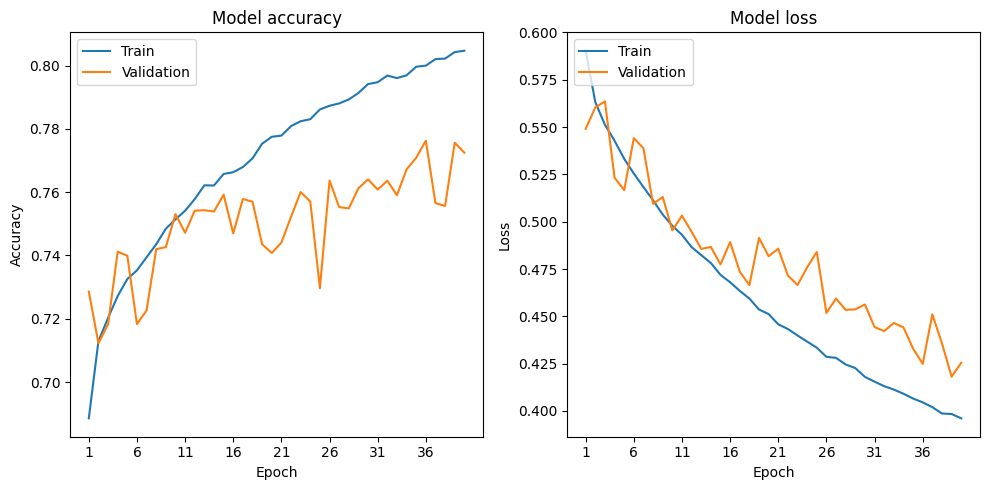

In [37]:
#Result Analysis for LSTM Model

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# Set x-axis ticks to intervals of 5
epochs = len(history.history['accuracy'])
x_ticks = np.arange(0, epochs, 5)  # Create ticks at intervals of 5
plt.xticks(x_ticks, x_ticks + 1)  # Set the ticks and labels (starting from 1)
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# Set x-axis ticks to intervals of 5 (for loss plot as well)
plt.xticks(x_ticks, x_ticks + 1)
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [39]:
# Scale numerical features for training and testing sets (using resampled data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)  # Scale resampled training data
X_test_scaled = scaler.transform(X_test)  # Scale test data using the same scaler


# Logistic Regression Model Training and Tuning
# Define the parameter grid for Grid Search
param_grid = {
    'C': [0.5, 1, 5],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced']
}

# Create a Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Create GridSearchCV object with recall scoring
grid_search = GridSearchCV(log_reg, param_grid, cv=2, scoring='recall')

# Fit the GridSearchCV object to the scaled, resampled training data
grid_search.fit(X_train_scaled, y_train_resampled)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)


# 5. Model Evaluation
# Predict on the test set using the best model
y_pred_log_reg = best_model.predict(X_test_scaled)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred_log_reg)
precision = precision_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)
f1 = f1_score(y_test, y_pred_log_reg)

print("Optimized Logistic Regression Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Optimized Logistic Regression Model Evaluation Metrics:
Accuracy: 0.727631160572337
Precision: 0.42786023785378446
Recall: 0.6629052992429653
F1 Score: 0.520058269834155


In [ ]:
#SVC

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have X_train_resampled, y_train_resampled, X_test, y_test

# --- Gradient Boosting Machines (GBM) ---

# 1. Create a GBM classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)

# 2. Define the parameter grid for hyperparameter tuning
param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

# 3. Create GridSearchCV object
grid_search_gbm = GridSearchCV(gbm_classifier, param_grid_gbm, cv=5, scoring='precision')

# 4. Fit the GridSearchCV object to the resampled training data
grid_search_gbm.fit(X_train_resampled, y_train_resampled)

# 5. Get the best hyperparameters and model
best_params_gbm = grid_search_gbm.best_params_
best_gbm_model = grid_search_gbm.best_estimator_

print("Best Hyperparameters (GBM):", best_params_gbm)

# 6. Predict on the test set using the best model
y_pred_gbm = best_gbm_model.predict(X_test)

# 7. Evaluate the performance
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
precision_gbm = precision_score(y_test, y_pred_gbm)
recall_gbm = recall_score(y_test, y_pred_gbm)
f1_gbm = f1_score(y_test, y_pred_gbm)

print("GBM Model Evaluation Metrics:")
print("Accuracy:", accuracy_gbm)
print("Precision:", precision_gbm)
print("Recall:", recall_gbm)
print("F1 Score:", f1_gbm)


# --- Support Vector Machines (SVM) with RBF kernel ---

# 1. Create an SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf', random_state=42, probability=True)

# 2. Define the parameter grid for hyperparameter tuning
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
}

# 3. Create GridSearchCV object
grid_search_svm = GridSearchCV(svm_classifier, param_grid_svm, cv=5, scoring='precision')

# 4. Fit the GridSearchCV object to the resampled training data
grid_search_svm.fit(X_train_resampled, y_train_resampled)

# 5. Get the best hyperparameters and model
best_params_svm = grid_search_svm.best_params_
best_svm_model = grid_search_svm.best_estimator_

print("Best Hyperparameters (SVM):", best_params_svm)

# 6. Predict on the test set using the best model
y_pred_svm = best_svm_model.predict(X_test)

# 7. Evaluate the performance
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("SVM Model Evaluation Metrics:")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1 Score:", f1_svm)



Best Hyperparameters (GBM): {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
GBM Model Evaluation Metrics:
Accuracy: 0.841939586645469
Precision: 0.6032343368592351
Recall: 0.8471646907584631
F1 Score: 0.7046872215291392


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ... (rest of your code from the previous response) ...

# --- Calculate and print ROC AUC for GBM ---
y_proba_gbm = best_gbm_model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
roc_auc_gbm = roc_auc_score(y_test, y_proba_gbm)
print("GBM ROC AUC:", roc_auc_gbm)

# --- Calculate and print ROC AUC for SVM ---
y_proba_svm = best_svm_model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)
print("SVM ROC AUC:", roc_auc_svm)